## Семинар 8: "Снижение размерности"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

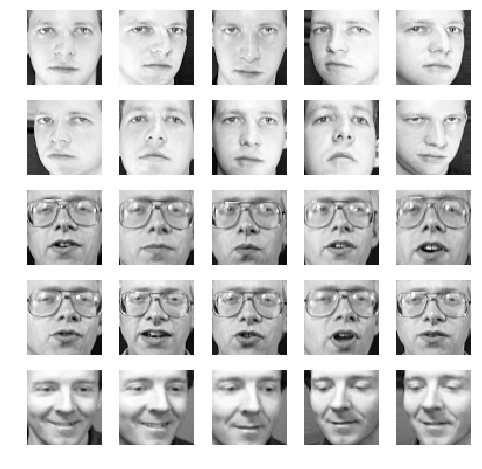

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
clf = PCA(n_components=400)
clf.fit(X.reshape(-1, 64*64))

res = clf.components_

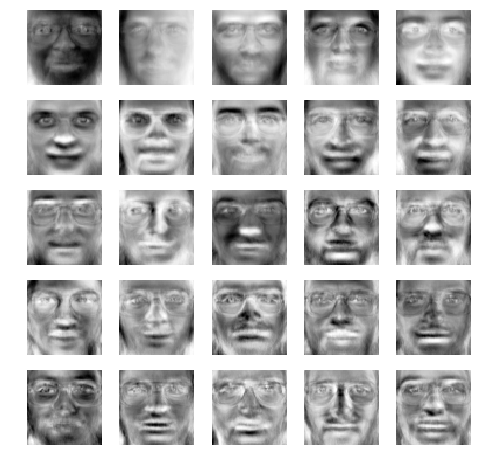

In [6]:
res.shape

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(res[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.explained\_variance\_ratio\_</b> и <b>np.cumsum()</b>

In [7]:
np.cumsum(clf.explained_variance_ratio_)[:10]

array([0.23812734, 0.37806708, 0.45775324, 0.5077365 , 0.543835  ,
       0.57540435, 0.5996727 , 0.62003666, 0.6396178 , 0.65633905],
      dtype=float32)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют? Чему соответствуют главные компоненты?</i>

In [8]:
# Код для отображения изображений в 2D
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

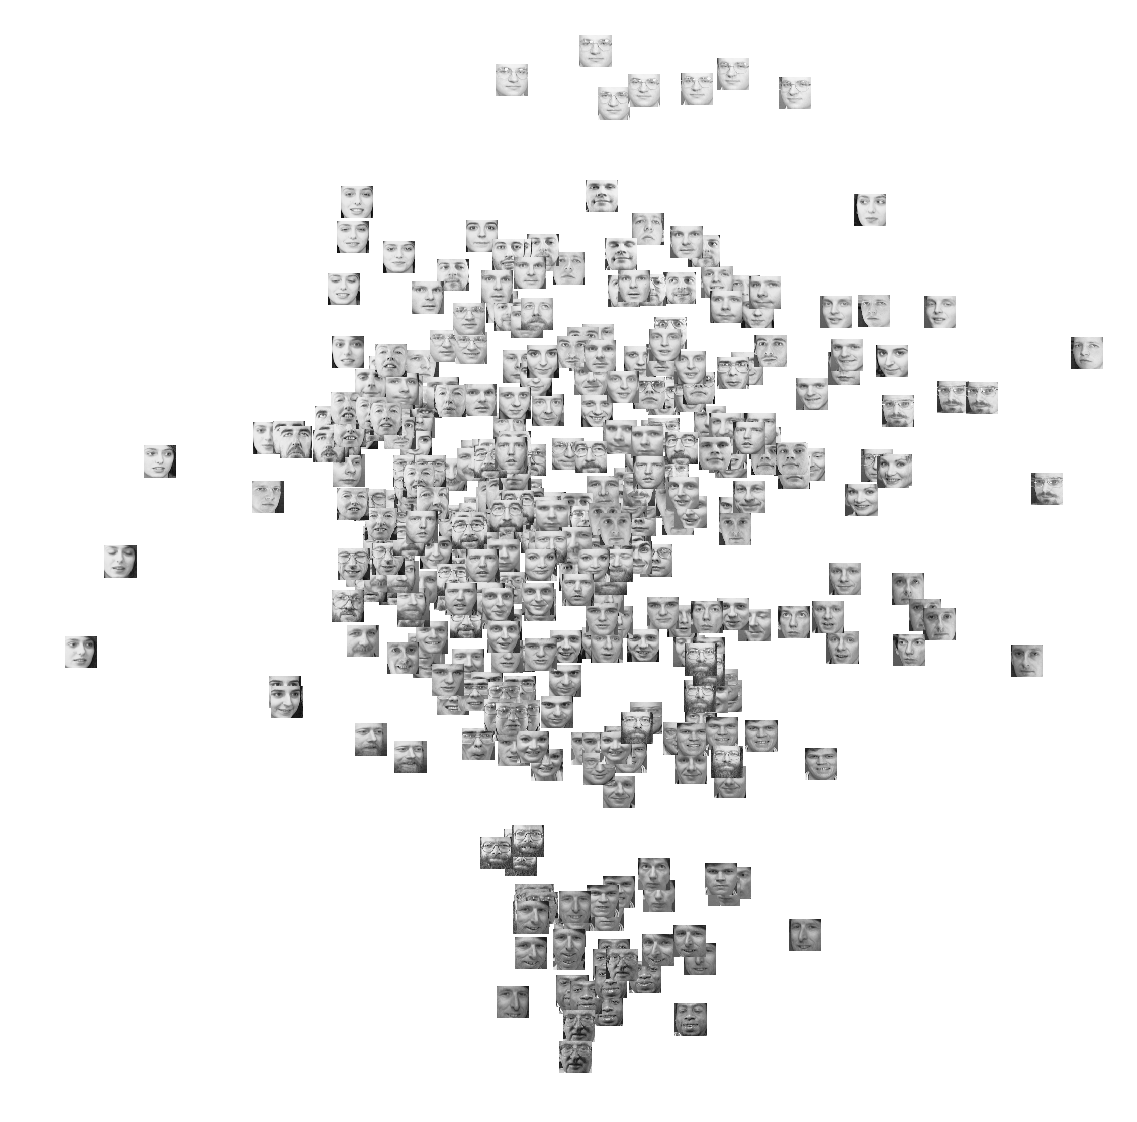

In [9]:
clf = PCA(n_components=2)
emb = clf.fit_transform(X)
plot_dataset(X[:, :], emb)

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [10]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
      super().__init__()

      encoder = []
      decoder = []

      def add_layer(layer, params):
        encoder.append(layer(*params))
        decoder.append(layer(*params[::-1]))
      
      activation = nn.Sigmoid
      add_layer(nn.Linear, (64**2, 200))
      add_layer(activation, tuple())
      add_layer(nn.Linear, (200, 10))
      add_layer(activation, tuple())
      #add_layer(nn.Linear, (100, 10))
      #add_layer(activation, tuple())

      self.encode = torch.nn.Sequential(*encoder)
      self.decode = torch.nn.Sequential(*decoder[::-1][1:])

    def forward(self, X):
      y = self.encode(X)
      y = self.decode(y)

      return y

aut = Autoencoder()

In [11]:
aut

Autoencoder(
  (encode): Sequential(
    (0): Linear(in_features=4096, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=10, bias=True)
    (3): Sigmoid()
  )
  (decode): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=4096, bias=True)
  )
)

In [12]:
X_torch = torch.from_numpy(X)
X_torch.size()

torch.Size([400, 4096])

In [13]:
#dataloader = torch.DataLoader(X, 10)

optim = torch.optim.Adam(aut.parameters(), 0.01)
#optim = torch.optim.SGD(aut.parameters(), 0.1)
X_torch = torch.from_numpy(X)

for i in range(500):
  res = aut(X_torch + torch.rand_like(X_torch) * 0.01)
  loss = torch.nn.MSELoss()(res, X_torch)
  print(i, loss.item())

  optim.zero_grad()
  aut.zero_grad()

  loss.backward()
  optim.step()  

0 0.4090448319911957
1 0.27870097756385803
2 0.24120134115219116
3 0.17323192954063416
4 0.15945500135421753
5 0.13982485234737396
6 0.10888882726430893
7 0.08425375819206238
8 0.07841240614652634
9 0.08467208594083786
10 0.08527106046676636
11 0.07244575023651123
12 0.0535423569381237
13 0.03981783986091614
14 0.03621019795536995
15 0.039826419204473495
16 0.044597700238227844
17 0.0461147241294384
18 0.04336480423808098
19 0.037887249141931534
20 0.03210220858454704
21 0.02795262262225151
22 0.02620883099734783
23 0.02642335370182991
24 0.027404911816120148
25 0.027952706441283226
26 0.02746489830315113
27 0.026100140064954758
28 0.024479646235704422
29 0.023215921595692635
30 0.022588973864912987
31 0.022500989958643913
32 0.02263724058866501
33 0.022680191323161125
34 0.022458652034401894
35 0.0219887588173151
36 0.021422091871500015
37 0.020944813266396523
38 0.020678546279668808
39 0.020626548677682877
40 0.020686974748969078
41 0.020721523091197014
42 0.02063666470348835
43 0.02

335 0.019267648458480835
336 0.019267648458480835
337 0.019267648458480835
338 0.019267648458480835
339 0.019267648458480835
340 0.019267648458480835
341 0.019267648458480835
342 0.019267648458480835
343 0.019267648458480835
344 0.019267648458480835
345 0.019267648458480835
346 0.019267648458480835
347 0.019267648458480835
348 0.019267648458480835
349 0.019267648458480835
350 0.019267648458480835
351 0.019267648458480835
352 0.019267648458480835
353 0.019267648458480835
354 0.019267648458480835
355 0.019267648458480835
356 0.019267648458480835
357 0.019267648458480835
358 0.019267648458480835
359 0.019267648458480835
360 0.019267648458480835
361 0.019267648458480835
362 0.019267648458480835
363 0.019267648458480835
364 0.019267648458480835
365 0.019267648458480835
366 0.019267648458480835
367 0.019267648458480835
368 0.019267648458480835
369 0.019267648458480835
370 0.019267648458480835
371 0.019267648458480835
372 0.019267648458480835
373 0.019267648458480835
374 0.019267648458480835


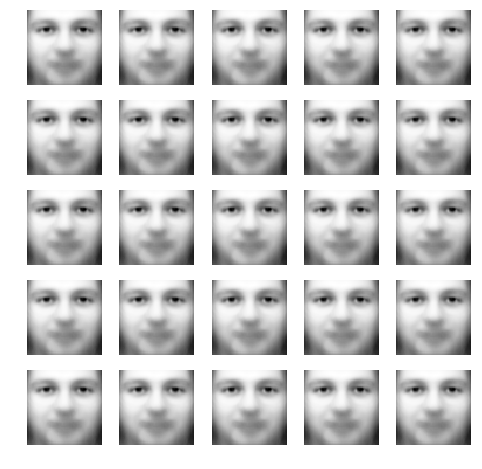

In [14]:
with torch.no_grad():
  res = aut(X_torch[:25, :]).numpy()
  #res = X_torch[:25, :].numpy()

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(res[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 2.2 Какое качество восстановления удалось получить?</i>

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: